# Visualize GO analysis

In [1]:
import numpy as np
import pandas as pd

In [2]:
def get_top_GO(tissue, fn, label):
    df = pd.read_excel(fn).sort_values('p_uncorrected').head(10)
    df['Log10'] = -np.log10(df['p_fdr_bh'])
    df['Tissue'] = tissue
    df['Bias'] = label
    return df

In [4]:
tissue = 'dlpfc'
config = {
    'All': 'GO_analysis_allDEG.xlsx',
    'AA': 'GO_analysis_downregulated.xlsx',
    'EA': 'GO_analysis_upregulated.xlsx',
}

df = pd.DataFrame()
for bias in ['All', 'AA', 'EA']:
    try:
        df = pd.concat([df, get_top_GO(tissue, config[bias], bias)], axis=0)
    except FileNotFoundError:
        print("There is no enrichment for {}!".format(bias))

fac = []
for ii in range(df.shape[0]):
    xx, yy = df[['ratio_in_study']].iloc[ii, 0].split('/')
    fac.append((int(xx) / int(yy)) * 2)
    
df['geneRatio'] = fac
print(np.min(fac), np.max(fac))

There is no enrichment for EA!
0.2347417840375587 0.717948717948718


In [5]:
df.to_csv("%s_GO_analysis.tsv" % tissue, sep='\t', index=False)

## Plot 

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R -i df
library(ggplot2)
library(tidyverse)

save_plot <- function(p, fn, w, h){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(file=paste0(fn,ext), plot=p, width=w, height=h)
    }
}

plot_GO <- function(){
    cbPalette <- c("#000000", "Red", "Blue")
    gg1 = df %>%
        ggplot(aes(x=Log10, y=name, color=Bias, size=geneRatio)) + 
        geom_point(shape=18, alpha=0.8) + labs(y='', x='-Log10 (FDR)') + 
        theme_bw(base_size=15) + 
        scale_colour_manual(name="Ancestry", values=cbPalette, 
                            labels=c("All", "AA Bias", "EA Bias")) +
        geom_vline(xintercept = -log10(0.05), linetype = "dotted") +
        theme(axis.title=element_text(face='bold'),
              strip.text=element_text(face='bold'))
    return(gg1)
}

R[write to console]: -- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

R[write to console]: v tibble  3.1.2     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

R[write to console]: -- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



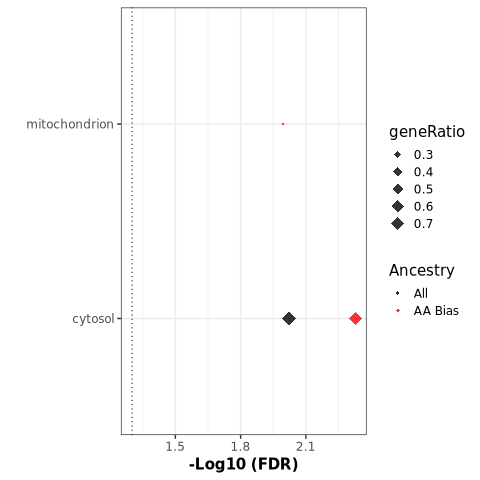

In [8]:
%%R
gg1 = plot_GO()
print(gg1)
save_plot(gg1, "ancestry_DTU_GO_top10_stacked", 6, 6)